# Some More Models on Binary Data
- categories: [Julia, Turing]

To get myself comfortable with Julia and `Turing.jl`, I wrote out a bunch of toy models on the simplest of datasets: a simple vector of binary outcomes. To keep myself honest and to have something to refer to, I'm reproducing them here.

In [56]:
#collapse
using Turing
using Bijectors
using Gadfly
using DataFrames, DataFramesMeta
Gadfly.set_default_plot_size(900px, 300px)

## Sequential Dependencies

The preceeding examples are about as far as coin flipping can take us, so let's begin exploring data that has more interesting structure. The first challenge we'll tackle is dependence between subsequent data elements. This is cheating a little bit, since we're no longer strictly dealing with binary data as we are also incorporating the order of the elements. In my opinion, this lives in the realm of prior knowledge: we believe a priori that the sort order of the data we received is equal to the temporal order of the data as it was generated. 

Here is a very simple model to capture this dependency:

$$\begin{aligned}
\beta_0 &\sim \mathrm{Beta}(1,1)\\
\beta_1 &\sim \mathrm{Beta}(1,1)\\
y_i &\sim \begin{cases} \mathrm{Bernoulli}(\beta_0) & y_{i-1} = 0 \\ \mathrm{Bernoulli}(\beta_1) & y_{i-1} = 1 \end{cases}
\end{aligned}$$

Note that if we incorrectly accepted an assumption of independence as in our previous models then our point estimate of `p` will not converge as quickly as expected, and our confidence intervals will be much too narrow. In other words, if we have positive autocorrelation (flipping a 1 is more likely if the preceeding flip was also a 1, and the reverse) then our estimates will just be wrong unless we account for it explicitly.

Let's generate some data in a way that very explicitly shows the connection to the previous datapoint:

In [44]:
data_autocor = [1]
p_1 = 0.85
p_2 = 0.35
for i in 2:1000
    if data_autocor[i-1] == 1
        p = p_1
    else
        p = p_2
    end
    data_autocor = cat(data_autocor, rand(Bernoulli(p)), dims=1)
end

And here's a model - it's not an accident that the model code looks so close to the data generating code!

In [45]:
@model function coinflip_autocor(y::Array{Int64})
    # prior on p
    p_1 ~ Beta(1, 1)
    p_2 ~ Beta(1, 1)
    
    y[1] ~ Bernoulli(p_1)       # I arbitrarily chose p_1
    for i in 2:length(y)
        if y[i-1] == 1
            p = p_1
        else
            p = p_2
        end
        y[i] ~ Bernoulli(p)
    end
end;

Here are the estimates of the two parameters:

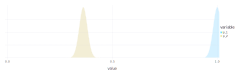

In [60]:
#collapse
chain_autocor = sample(coinflip_autocor(data_autocor), HMC(ϵ, τ), iterations, progress=false)[500:end];
ch_autocor_df = @linq DataFrame(chain_autocor) |> 
    select(:p_1, :p_2) |> 
    DataFrames.stack();
plot(DataFrame(ch_autocor_df), x=:value, color=:variable, Theme(alphas=[0.6]),
    Stat.density(bandwidth=0.02), Geom.polygon(fill=true, preserve_order=true),
    Coord.cartesian(xmin=0.0, xmax=1.0, ymin=0.0), Guide.yticks(label = false)
)

We have less certainty about $p_2$ than $p_1$. This is predictable from the data generation process: because heads are more likely to beget heads than tails are to beget tails (ie $p_1$ is closer to 1 than $p_2$ is to 0), we have more examples drawing from the $p_1$ distribution.

How to do this with an honest covariance matrix? ie over zip(y[:-1], y[2:])?
What about a "rich get richer" scenario? P(1) ~ b + length of streak of 1s
- would look good but how to diagnose issues?
    - distributions of streaks! a lot of extremely long streaks, a lot of short streaks... 

what about a "machine error" - double readings for both or one of 1s / 0s?

## Wide Dependencies: Rich get Richer
Look, we're long passed the physical analogy making sense for this data so just roll with it for now. The idea for this scenario is a minor extension of the former: every consecutive flip heads makes it more likely the next flip will also be heads, and the reverse for tails.

In [41]:
function streaks(arr)
    streaks = []
    val = arr[1]
    current_streak = 1
    for i in 2:length(arr)
        next_val = arr[i]
        if next_val == val
            current_streak = current_streak + 1
        else
            streaks = cat(streaks, current_streak, dims=1)
            val = next_val
            current_streak = 1
        end
    end
    streaks = cat(streaks, current_streak, dims=1)
    return streaks
end;

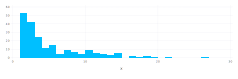

In [61]:
plot(DataFrame(x=streaks(data_autocor)), x=:x, Geom.histogram)

## Many Streams with Discrete Biases

"data on several coins from specific mints. Coin of unknown origin with 10 flips, what is P(heads) on next flip?"

## Many Streams with Continuous Biases

All coins come from one rather shitty mint. How shitty is that mint, and how shitty is this coin?

$$\begin{aligned}
\mu_{mint} &\sim \mathrm{Normal}(0,1) \\
\sigma_{mint} &\sim \mathrm{Normal}(1, 2) \\
\mu_{coin} &\sim \mathrm{Normal}(\mu_{mint}, \sigma_{mint}) \\
ys &\sim \mathrm{Bernoulli}(\mu_{coin}) \\ 
\end{aligned}$$

Compare naive estimate and regularized estimate. Note: regularization lets us "share error" between

## "Seasonal" data
e.g. hourly aggregate from a motion sensor in a shop: "there was motion in the shop over the past hour"

## Extremely sparse data?